# Euristica 2
il codice che segue risolve il CVRP tramite l'utilizzo di un **algoritmo genetico**.   

La **popolazione iniziale**  è un insieme di soluzioni candidate (chiamate individui o cromosomi) generate all'inizio del processo evolutivo. Queste soluzioni rappresentano possibili risposte al problema che l'algoritmo cerca di risolvere. La qualità di queste soluzioni iniziali può influenzare la velocità e l'efficacia con cui l'algoritmo trova la soluzione ottimale.


La funzione **crossover** serve a combinare due soluzioni esistenti (genitori) per crearne di nuove (figli). è una delle operazioni principali negli algoritmi genetici e aiuta a esplorare nuove parti dello spazio delle soluzioni combinando tratti di soluzioni già esistenti.

### Lettura dati da file

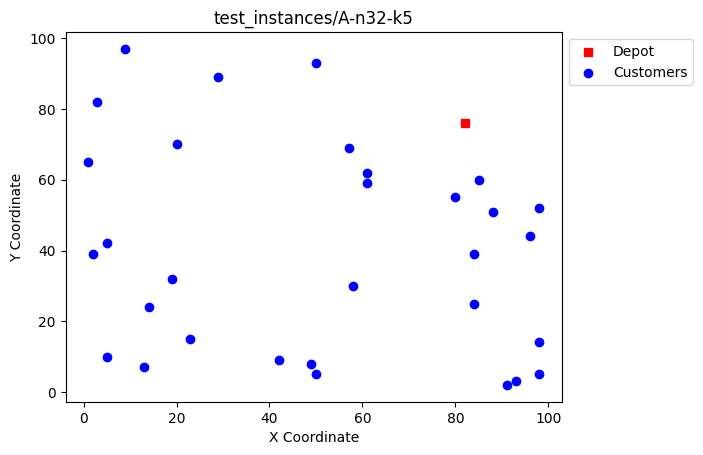

In [1]:
import numpy as np

filename = "test_instances/A-n32-k5"
#filename = "test_instances/P-n45-k5"
#filename = "test_instances/A-n62-k8" 
#filename = "test_instances/A-n80-k10" 
#filename = "test_instances/P-n101-k4" 

#Lettura soluzione

file_sol = open(filename + ".sol", "r")
line_sol = file_sol.readlines()

rowInd = 0

while not line_sol[rowInd].startswith("Cost"):
        rowInd =  rowInd + 1

solution_cost = int(line_sol[rowInd].split()[1])

file = open(filename + ".vrp", "r")
line = file.readlines()

k = int(filename[-1])
coordinates = {}


demands = {}

rowInd = 0
while not line[rowInd].startswith("EOF"):
    if line[rowInd].startswith("DIMENSION") :
        n = int(line[rowInd].split()[2])
        rowInd =  rowInd + 1
    elif line[rowInd].startswith("CAPACITY") :
        Q = int(line[rowInd].split()[2])
        rowInd =  rowInd + 1
    elif line[rowInd].startswith("NODE_COORD_SECTION") :
        rowInd =  rowInd + 1
        for i in range(n):
            coordinates[int(line[rowInd].split()[0]) - 1] = (int(line[rowInd].split()[1]), int(line[rowInd].split()[2]))
            rowInd = rowInd + 1
    elif line[rowInd].startswith("DEMAND_SECTION") :
        rowInd =  rowInd + 1
        for i in range(n):
            demands[int(line[rowInd].split()[0]) - 1] = (int(line[rowInd].split()[1]))
            rowInd = rowInd + 1
    else:
        rowInd =  rowInd + 1

distance_matrix = {}

for i in range(n):
    for j in range(n):
            # Calcola la distanza euclidea tra i punti i e j
            dist = np.sqrt((coordinates[i][0] - coordinates[j][0])**2 +
                           (coordinates[i][1] - coordinates[j][1])**2)
            # Assegna la distanza alla matrice delle distanze
            distance_matrix[i, j] = dist

#plot dell'instaza
import matplotlib.pyplot as plt
plt.scatter(coordinates[0][0], coordinates[0][1], c='r', marker='s', label='Depot')
for i in range(1,n):
    if i == 1:  # Specifica l'etichetta solo per il primo punto
     plt.scatter(coordinates[i][0], coordinates[i][1], c='b', label='Customers')
    else:
        plt.scatter(coordinates[i][0], coordinates[i][1], c='b')

    plt.title(filename)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    # Aggiungere la legenda fuori dalla figura
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Funzioni per la stampa dei risultati

In [2]:
import matplotlib.pyplot as plt
import time

def plot_routes(routes, coordinates):

    plt.figure(figsize=(10, 8))

    i=1
    # Disegna ogni rotta

    for route in routes.values():

        x_coords = [coordinates[node][0] for node in route]
        y_coords = [coordinates[node][1] for node in route]

        plt.plot(x_coords, y_coords, marker='o', label='Route'+str(i))
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        i=i+1

    plt.plot(coordinates[0][0], coordinates[0][1], c='r', marker='s', markersize=7)
    plt.scatter(coordinates[0][0], coordinates[0][1], c='r', marker='s', label='Depot')
    '''
    # Disegna i nodi
    for idx, (x, y) in enumerate(coordinates.values()):
        if idx == 0:
                plt.scatter(coordinates[0][0], coordinates[0][1], c='r', marker='s', label='Depot')
        else:
            plt.scatter(x, y, c='red')
            plt.text(x, y, f'{idx}', fontsize=12, ha='right')
    '''
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.grid()
    plt.show()

def print_results(routes, coordinates):

    time = end - start
    cost = 0
    cost_p = 0
    demand_p = 0
    print("\n")
    print("="*50+"\033[1m Routes \033[0m"+"="*50)
    print("\n")
    j=1
    for elem in routes:
        #print("\n")
        print(f"Route {j}: \t{routes[elem]}")
        #print(routes[elem])
        #print(sum(demands[node] for node in routes[elem]))
        j = j+1
        route = routes[elem]
        for i in range(len(route)-1):
            cost = cost + distance_matrix[route[i],route[i+1]]
            cost_p = cost_p + distance_matrix[route[i],route[i+1]]
            demand_p = demand_p + demands[route[i]]
        print(f"Cost: \t\t{cost_p:.2f}")
        print(f"Demand: \t{demand_p}\n")
        cost_p = 0
        demand_p = 0

    gap = (abs(cost-solution_cost)/solution_cost)*100
    print("="*120)
    print(f"\033[1m\nTotal Cost: \t{cost:.2f}\033[0m")
    print(f"\033[1mTotal Time: \t{time:.2f}\033[0m")
    print(f"\033[1mGap: \t\t{gap:.2f}%\033[0m")

    plot_routes(routes, coordinates)

## Euristiche per definire la popolazione iniziale


In [3]:
import numpy as np

def Clarke_and_Wright_1(savings,Q,demands,n):                                   #la funzione ora prende in ingresso la lista dei risparmi

    # Costruzione delle rotte
    routes = {i: [i] for i in range(1, n)}                                      #inizializza una rotta per ogni nodo
    capacities = {i: demands[i] for i in range(1, n)}                           #capacità corrente di ciascuna rotta
    assigned_vehicles = {i: i for i in range(1, n)}                             #mappa ogni nodo al veicolo assegnato

    # Unisci le rotte basate sui risparmi
    for s, i, j in savings:
        if i in assigned_vehicles and j in assigned_vehicles:                   #se i e j sono assegnati
            if assigned_vehicles[i] != assigned_vehicles[j]:                    #se i e j sono assegnati a veicoli diversi
                vehicle_i = assigned_vehicles[i]                                #identifico il veicolo assegnato a i
                vehicle_j = assigned_vehicles[j]                                #identifico il veicolo assegnato a j
                if vehicle_i in routes and vehicle_j in routes:                 #verifico che i veicoli vehicle_i e vehicle_j abbiano delle rotte associate
                    route_i = routes[vehicle_i]                                 #recupero le rotte dei veicoli
                    route_j = routes[vehicle_j]
                    if capacities[vehicle_i] + capacities[vehicle_j] <= Q:      #verifico se l'unione delle rotte rispetta la capacità del veicolo
                        if route_i[-1] == i and route_j[0] == j:                #verifico se le rotte possono essere concatenate
                            routes[vehicle_i] = route_i + route_j               #combino route_i e route_j assegnando la nuova rotta a vehicle_i
                            capacities[vehicle_i] += capacities[vehicle_j]      #aggiungo la capacità di vehicle_j a quella di vehicle_i
                            for node in route_j:                                #assegno tutti i nodi di route_j a vehicle_i
                                assigned_vehicles[node] = vehicle_i
                            del routes[vehicle_j]                               #rimuovo vehicle_j da routes e capacities
                            del capacities[vehicle_j]

    #inserisco il nodo deposito in tutte le rotte
    for i in routes:
        route = routes[i]
        route.insert(0, 0)
        route.append(0)
        routes[i] = route

    return routes,assigned_vehicles

In [4]:
def Nearest_Neighbor(distance_matrix, demands, vehicle_capacity,n):

    routes = {}
    visited = set() #tiene traccia dei nodi visitati
    key = 0         #indice per le rotte dei veicoli
    depot = 0

    for v in range(1, n):                     #itera attraverso tutti i nodi escluso il deposito
        if v not in visited:                  #se il nodo corrente non è stato ancora visitato
            current_route = [depot]           #viene creata una nuova rotta a partire dal deposito
            current_load = demands[depot]     #inizializzo il carico alla domanda del deposito

            while current_load + demands[v] <= vehicle_capacity:  #itera finché la somma delle domande della rotta corrente più la domanda del nodo v è minore o uguale alla capacità del veicolo
                current_route.append(v)                           #aggiungo il nodo corrente alla rotta corrente
                visited.add(v)                                    # .. e alla lista dei nodi visitati
                current_load += demands[v]                        #aggiorno il carico del veicolo con la domanda del nodo

                # Trovo il più vicino nodo non visitato
                min_distance = float('inf')                             #inizializza la distanza minima a infinito
                nearest_node = None                                     #..e il nodo più vicino a None
                for u in range(n):                                      #itero su tutti i nodi
                    if u not in visited and u != v and u!= depot:       #se u non è stato visitato, non è il nodo corrente e non è il deposito
                        if distance_matrix[v, u] < min_distance:        #se la distanza tra u e v è minore di min_distance
                            min_distance = distance_matrix[v, u]        #aggiorno min distance
                            nearest_node = u                            #aggiono nearest node

                if nearest_node is None:
                    break

                v = nearest_node              #imposto il nodo corrente al nodo trovato

            current_route.append(depot)       #aggiungo il deposito alla rotta
            routes[key] = current_route       #memorizzo il percorso nel dizionario con la chiave corrente
            key += 1                          #aggiorno la chiave

    return routes

In [5]:
def Clarke_Wright_fusion(routes,distance_matrix,demands,Q,assigned_vehicles, k):

    while len(routes) > k:    #Continua finché il numero di rotte è maggiore di k
        # Trovo le due rotte con i costi di combinazione minimi
        best_savings = None
        best_i, best_j = None, None
        for i in routes:        #per ogni coppia di rotte i!=j
            for j in routes:
                if i != j:
                    # Calcolo i risparmi per combinare le rotte i e j
                    route_i = routes[i]
                    route_j = routes[j]
                    #stavolta  Il risparmio è calcolato come la differenza tra il costo di inviare il veicolo dal penultimo nodo di route_i
                    #al deposito e poi dal deposito al primo nodo di route_j meno il costo diretto dall'ultimo nodo di route_i al primo nodo di route_j
                    saving = distance_matrix[route_i[-2], 0] + distance_matrix[0, route_j[1]] - distance_matrix[route_i[-2], route_j[1]]
                    if best_savings is None or saving > best_savings: #verifica del risparmio
                        if sum(demands[node] for node in route_i) + sum(demands[node] for node in route_j) < Q:  #vincolo capacità del veicolo
                            best_savings = saving
                            best_i = i
                            best_j = j
        if best_i is not None and best_j is not None:                 #se trovo un risparmio
            # Combina le rotte best_i e best_j
            routes_best_i = routes[best_i]
            routes_best_j = routes[best_j]
            routes[best_i] = routes_best_i[:-1] + routes_best_j[1:]   #combino gli ultimi nodi di routes_best_i con i primi nodi di routes_best_j.

            for node in routes[best_j]:
                assigned_vehicles[node] = best_i                      #Tutti i nodi di routes[best_j] vengono assegnati a best_i.
            del routes[best_j]                                        #routes[best_j] viene eliminato dalla lista delle rotte.
        else:
            break
    return routes,assigned_vehicles

In [6]:
def three_opt(route, distance_matrix):
    n = len(route)
    best_route = route
    improved = True

    while improved:
        improved = False
        for i in range(1, n - 4):
            for j in range(i + 1, n - 3):
                for k in range(j + 1, n - 2):
                    new_routes = generate_all_3opt_swaps(route, i, j, k)
                    for new_route in new_routes:
                        if calculate_route_length(new_route, distance_matrix) < calculate_route_length(best_route, distance_matrix):
                            best_route = new_route
                            improved = True
                            route = best_route

    return best_route

def generate_all_3opt_swaps(route, i, j, k):
    # Estrazione dei segmenti dalla rotta originale
    seg1 = route[1:i]
    seg2 = route[i:j+1]
    seg3 = route[j+1:k+1]
    seg4 = route[k+1:]
    
    new_routes = []
    
    # Non fare nulla
    new_routes.append([route[0]] + seg1 + seg2 + seg3 + seg4)
    
    # Invertire seg2
    new_routes.append([route[0]] + seg1 + seg2[::-1] + seg3 + seg4)
    
    # Invertire seg3
    new_routes.append([route[0]] + seg1 + seg2 + seg3[::-1] + seg4)
    
    # Invertire seg2 e seg3
    new_routes.append([route[0]] + seg1 + seg2[::-1] + seg3[::-1] + seg4)
    
    # Riarrangiare con inversione
    new_routes.append([route[0]] + seg1 + seg3 + seg2 + seg4)
    
    # Un'altra riarrangiamento con inversione
    new_routes.append([route[0]] + seg1 + seg3 + seg2[::-1] + seg4)
    
    # L'ultima permutazione con inversione
    new_routes.append([route[0]] + seg1 + seg3[::-1] + seg2 + seg4)
    
    return new_routes

def calculate_route_length(route, distance_matrix):
    length = 0
    for i in range(len(route) - 1):
        length += distance_matrix[route[i], route[i + 1]]
    return length


Il codice seguente definisce una semplice euristica che cerca di trovare una soluzione ammissibile per il problema del veicolo a capacità (CVRP), mescolando i clienti in modo casuale e generando rotte finché non viene trovata una soluzione con esattamente k rotte.

Viene utilizzata quando le altre euristiche definite non trovano più soluzioni ammissibili.

In [7]:
import random

def simple_heuristics(demands,k,Q,coordinates,n):
  admissible = 0
  while admissible == 0:                            #finchè non viene trovata una soluzione ammissibile
    routes = {}                                     #inizializzo il dizionario per le rotte
    clients_demands = demands.copy()                #conservo una copia delle domande
    clients_demands.pop(0)                          #elimino la domanda del nodo deposito
    # Converto il dizionario in una lista di tuple
    lista_coppie = list(clients_demands.items())

    # Mischio la lista di domande
    random.shuffle(lista_coppie)

    # Ricreare il dizionario con l'ordine mischiato
    clients_demands = dict(lista_coppie)

    # Calcolo i percorsi in questo modo:
    # Creo un percorso finché non riempo la capacità -> se la riempo mi fermo e ne creo un altro
    # Se creo k percorsi ed ho inserito tutti i nodi la soluzione è ammissibile
    # Altrimenti ripeto l'algoritmo finché non trovo una soluzione ammissibile

    cost = 0
    route = [0]                                     #inizializzo la rotta con il solo nodo deposito

    for client in clients_demands:
      demand = clients_demands[client]
      if cost + demand <= Q:                        #se l'aggiunta della domanda del cliente non eccede la capacità del veicolo
          route.append(client)                      #aggiungo il cliente
          cost += demand
      else:
        route.append(0)                             #altrimenti chiudo la rotta tornando al deposito
        routes[len(routes)+1] = route               #memorizzo il percorso
        route = [0,client]                          #inizializzo una nuova rotta con il cliente
        cost = demand

    route = route + [0]                             #chiusura dell'ultima rotta tornando al deposito
    routes[len(routes)+1] = route                   #aggiunta della rotta

    if len(routes) == k:                            #se ho aggiunto k rotte
      admissible = 1                                #la soluzione diventa ammissibile
      break
  return routes

## **Funzioni di utilità per l'algoritmo genetico**

### Fusione di percorsi

In [8]:
def merge_routes(routes, k):
    
    while len(routes) > k:
        min_cost_increase = float('inf')
        merge_idx = (0, 1)
        for i in range(len(routes)):
            for j in range(i + 1, len(routes)):
                merged_route = routes[i] + routes[j][1:]
                merged_cost = calculate_total_cost(merged_route, distance_matrix)
                original_cost = calculate_total_cost(routes[i], distance_matrix) + calculate_total_cost(routes[j], distance_matrix)
                cost_increase = merged_cost - original_cost
                if cost_increase < min_cost_increase:
                    min_cost_increase = cost_increase
                    merge_idx = (i, j)
        i, j = merge_idx
        routes[i] = routes[i] + routes[j][1:]
        del routes[j]
    return routes

### Popolazione iniziale

Le euristiche utilizzate per definire la popolazione iniziale sono *Clarke and Write* e *Nearest Neighbor* ed è stata implementata un'euristica semplice nel caso in cui le precedenti fallissero nel trovare soluzioni ammissibili. Per garantire una popolazione di soluzioni eterogenee, i parametri saving e Q vengono definiti in maniera randomica.  

In [9]:
import random

def calculate_total_cost(route, distance_matrix):
    total_cost = 0
    for i in range(len(route) - 1):
        total_cost += distance_matrix[route[i], route[i + 1]]
    return total_cost

#funzione che genera la popolazione iniziale di soluzioni.
#La popolazione è una lista di possibili soluzioni (insiemi di percorsi)
def initial_population(coordinates, Q, demands, pop_size, k):

    population = []
    savings = []

    #calcolo e ordinamento dei saving
    for i in range(1, n):
        for j in range(i + 1, n):
            s_ij = distance_matrix[0, i] + distance_matrix[0, j] - distance_matrix[i, j]
            savings.append((s_ij, i, j))
    savings.sort(reverse=True, key=lambda x: x[0])

    thresh = int(pop_size/3) + 15                                                   #soglia che definisce un numero di tentativi massimo
    i = 0                                                                           #per trovare una soluzione ammissibile, prima di passare ad un'altra euristica

    while len(population) < pop_size:
        if i < thresh:

          first_15 = savings[:15]                                                   #mischio i primi 15 savings
          random.shuffle(first_15)
          savings[:15] = first_15

          Q1 = max(demands)                                                         #adatto la capacità del veicolo per bilanciare i nodi lungo i percorsi
          Q1 = random.randint(Q1,min(Q1*2,Q))                                       #la nuova capacità è calcolata randomicamente in un range di valori che va
                                                                                    #dalla domanda massima al minimo tra Q1*2 e Q
          first_choice = random.randint(0,1)

          #randomicamente eseguo l'euristica di Clarke and Write o Nearest Neighbor per generare la popolazione iniziale
          if first_choice == 0:
              routes, assigned_vehicles = Clarke_and_Wright_1(savings,Q1,demands,n) #fornisce risultati differenti perchè cambiano savings e Q1
          else:
              routes = Nearest_Neighbor(distance_matrix, demands,Q1,n)              #fornisce risultati differenti perchè cambia Q1
              assigned_vehicles = {}
              for i in routes:
                  route = routes[i]
                  for elem in route:
                      assigned_vehicles[elem] = i

          solution, _ = Clarke_Wright_fusion(routes,distance_matrix,demands,Q,assigned_vehicles, k)

          # Conversione da dizionario a lista
          lista = []
          for sol in solution:
              lista.append(solution[sol])
          routes = lista

          admissibile = 1
          for route in routes:
              if sum(demands[i] for i in route) > Q or route == [0,0]:  #se la richiesta del percorso eccede la capacità del veicolo
                  admissibile = 0                                       #la soluzione non è ammissibile

          if admissibile == 1:                                          #se la soluzione è ammissibile
            for i in range(len(routes)):                                #la ottimizzo con 3-opt
                routes[i] = three_opt(routes[i],distance_matrix)

          if len(routes) <= k and admissibile == 1:                     #se è ancora ammissibile che non ne ho ancora trovate k la memorizzo
              population.append(routes)
          else:
            # Caso in cui la soluzione non è ammissibile
            i = i + 1
        else:
          solution = simple_heuristics(demands,k,Q,coordinates,n)       #se non trovo soluzioni ammissibili utilizzo l'euristica semplice definita

          # conversione in una lista
          lista = []
          for sol in solution:
              lista.append(solution[sol])
          routes = lista

          # Ottimizzazione percorsi                                     #dopdichè ottimizzo i percorsi
          for i in range(len(routes)):
                routes[i] = three_opt(routes[i],distance_matrix)
          population.append(routes)

    return population

### Crossover

Questa sezione di codice esegue il crossover tra due soluzioni per generare due nuove soluzioni. La funzione implementa uno scambio di sotto-sequenze tra i percorsi di due figli, garantendo al contempo l'integrità della soluzione, cioè che ogni città venga visitata una volta sola.

In [10]:
def crossover(parent1, parent2, k):

    #Controllo della lunghezza minima                                                           verifico che le soluzioni dei genitori abbiano abbastanza città per poter eseguire il crossover
    min_length = min(len(parent1[0]), len(parent2[0])) - 1
    if min_length <= 2:
        return parent1, parent2

    #Selezione dei punti di crossover
    start, end = sorted(random.sample(range(1, min(len(parent1[0]), len(parent2[0])) - 1), 2))  #seleziono randomicamente i punti di crossover

    #Creazione dei figli
    child1, child2 = [route[:] for route in parent1], [route[:] for route in parent2]           #i figli sono inizializzati come copia esatta dei genitori

    #Scambio delle città
    for i in range(start, end):                                                                 #start-end definisce il segmento dei cromosomi (percorsi) su cui si applica il crossover
        city1, city2 = child1[0][i], child2[0][i]                                               #city1 è la città nel percorso del primo figlio all'indice i

        for j in range(len(child1)):
            if city2 in child1[j]:                                                              #se city2 è presente in uno dei percorsi di child1, viene sostituita con city1 (e viceversa)
                                                                                                #questo assicura che la città city2 non compaia più nel percorso del primo figlio dopo
                                                                                                #essere stata sostituita con city1
                child1[j][child1[j].index(city2)] = city1
            if city1 in child2[j]:
                child2[j][child2[j].index(city1)] = city2

        child1[0][i], child2[0][i] = city2, city1                                               #le città city1 e city2 vengono scambiate nelle posizioni i dei rispettivi percorsi dei figli.

    #Verifica del numero massimo di percorsi                                                    se vengono generati più di k percorsi, questi vengono fusi
    if len(child1) > k:
        child1 = merge_routes(child1, k)
    if len(child2) > k:
        child2 = merge_routes(child2, k)

    return child1, child2

### Mutazione

La funzione *mutate* esegue una mutazione su un insieme di percorsi. La mutazione serve a introdurre variazioni casuali nei percorsi che mirano a mantenere la diversità genetica della popolazione durante l'esecuzione dell'algoritmo genetico

In [11]:
def mutate(routes, k):

    #Controllo della lunghezza dei percorsi
    if len(routes) <= 2:                                                                     #se il numero totale di percorsi (routes) è minore o uguale a 2, la funzione termina subito restituendo
        return routes                                                                        #i percorsi originali perché con meno di 3 percorsi la mutazione potrebbe non essere significativa.

    #Selezione di due percorsi casuali
    i, j = random.sample(range(len(routes)), 2)                                              #seleziona due percorsi distinti a caso
    route1, route2 = routes[i], routes[j]

    #Controllo della lunghezza dei percorsi selezionati
    if len(route1) > 2 and len(route2) > 2:                                                  #verifico che entrambi i percorsi selezionati abbiano più di due città per effettuare la mutazione
        #Selezione indici casuali nei percorsi
        idx1, idx2 = random.randint(1, len(route1) - 2), random.randint(1, len(route2) - 2)  #seleziono un indice casuale in ciascun percorso escludendo deposito e nodo di arrivo
        #Scambio elementi
        route1[idx1], route2[idx2] = route2[idx2], route1[idx1]                              #scambio gli elementi dei percorsi selezionati agli indici idx1 e idx2

    #Controllo numero di percorsi
    if len(routes) > k:                                                                      #se ottengo più di k percorsi li fondo
        routes = merge_routes(routes, k)

    return routes

## Tournament Selection

Seleziona un individuo (soluzione) dalla popolazione basandosi su un "torneo" casuale tra un sottoinsieme di individui. L'individuo con il miglior valore della funzione obiettivo nel torneo viene scelto per la riproduzione.

In [12]:
def tournament_selection(population, tournament_size):

    #Controllo della Dimensione del Torneo
    if len(population) < tournament_size:                     #se la dimensione della popolazione è minore della dimensione del torneo
        tournament_size = len(population)                     #la dimensione del torneo viene ridotta alla dimensione della popolazione

    #Selezione casuale dei partecipanti al torneo
    tournament = random.sample(population, tournament_size)   #selezione casuale di un sottoinsieme di individui dalla popolazione

    #Calcolo del miglior individuo del torneo
    return min(tournament, key=lambda routes: sum(calculate_total_cost(route, distance_matrix) for route in routes))

## Ricerca locale

La funzione ha lo scopo di migliorare un percorso esistente. Itera su ogni coppia di città nel percorso (esclusi il primo e l'ultimo punto) e crea un nuovo percorso scambiando le posizioni delle due città.

In [13]:
def local_search(route, distance_matrix):

    best_route = route
    best_cost = calculate_total_cost(route, distance_matrix)
    for i in range(1, len(route) - 2):
        for j in range(i + 1, len(route) - 1):
            new_route = route[:]
            new_route[i], new_route[j] = new_route[j], new_route[i]
            new_cost = calculate_total_cost(new_route, distance_matrix)
            if new_cost < best_cost:
                best_route, best_cost = new_route, new_cost

    return best_route

## **Algoritmo Genetico**

L'algoritmo genetico in questa funzione evolve una popolazione di soluzioni attraverso *selezione*, *crossover* e *mutazione*. Mantiene l'élite della popolazione per garantire la qualità della soluzione e utilizza la ricerca locale per  migliorare ulteriormente le soluzioni. L'obiettivo è minimizzare il costo totale dei percorsi rispettando i vincoli di capacità dei veicoli e il numero massimo di veicoli disponibili.

Nell'utilizzo dell'euristica è importante valutare un trade-off tra accuratezza e complessità computazionale, settando accuratamente i seguenti parametri:

*   ***pop_size***: dimensione della popolazione (numero di soluzioni) iniziale. Di default è impostata a 50.

*   ***generations***: numero di generazioni per l'evoluzione dell'algoritmo genetico. Di default è impostata a 10.

*   ***mutation_rate***: probabilità di mutazione. Di default è impostata a 0.015.

*   ***tournament_size***: dimensione del torneo per la selezione dei genitori. Di default è impostata a 2.





In [14]:
def genetic_algorithm(coordinates, distance_matrix, demands, Q, k, pop_size=50, generations=10, mutation_rate=0.015, tournament_size=2):

    #Creazione della popolazione iniziale
    population = initial_population(coordinates, Q, demands, pop_size, k)

    #Calcolo della miglior soluzione ammissibile iniziale
    best_solution = None                                                        #inizializzo best_solution a None e best_cost a infinito.
    best_cost = float('inf')
    for routes in population:
        admissible = 1
        cost = 0
        for route in routes:
            if sum(demands[i] for i in route) > Q:                               #controllo vincolo di capacità
                admissible = 0
            cost += calculate_total_cost(route, distance_matrix)
        if cost < best_cost and admissible:
            best_cost = cost
            best_solution = routes

    #Evoluzione della Popolazione
    for generation in range(generations):                                       #per ogni generazione
        new_population = []                                                     #creo una popolazione vuota
        #Ordino la popolazione corrente in base al costo totale di ogni soluzione
        population.sort(key=lambda routes: sum(calculate_total_cost(route, distance_matrix) for route in routes))

        # Creo la nuova generazione
        new_population.extend(population[:pop_size // 10])                      #mantiene l'élite, cioè il top 10% delle soluzioni ottimali della popolazione corrente, aggiungendole alla nuova popolazione
        while len(new_population) < pop_size:

            #Selezione dei genitori usando il tournament_selection.
            parent1 = tournament_selection(population, tournament_size)
            parent2 = tournament_selection(population, tournament_size)

            #Generazione dei figli attraverso il crossover
            child1, child2 = crossover(parent1, parent2, k)

            if parent1 != (child1 or child2) and parent2 != (child1 or child2): # Controllo che siano stati generati dei figli
              #Applico la mutazione con una certa probabilità
              if random.random() < mutation_rate:
                  child1 = mutate(child1, k)
              if random.random() < mutation_rate:
                  child2 = mutate(child2, k)

              #Aggiungo i figli alla nuova popolazione
              new_population.append(child1)
              new_population.append(child2)

        #Aggiornamento della popolazione e Ricerca Locale
        population = new_population
        for i in range(len(population)):
            for j in range(len(population[i])):
                #population[i][j] = three_opt(population[i][j], distance_matrix)  #Applica una ricerca locale per migliorare ulteriormente ogni percorso in ogni soluzione della popolazione
                population[i][j] = local_search(population[i][j], distance_matrix)  #Applica una ricerca locale per migliorare ulteriormente ogni percorso in ogni soluzione della popolazione

        current_cost = best_cost

        #Calcolo della nuova soluzione ottima
        for routes in population:
            admissible = 1
            cost = 0
            for route in routes:
                if sum(demands[i] for i in route) >= Q or route == [0,0]:
                    admissible = 0
                cost += calculate_total_cost(route, distance_matrix)
            if cost < current_cost and admissible:
                current_cost = cost
                current_best = routes

        if current_cost < best_cost:
            print("Cambio soluzione ottima alla generazione " + str(generation))
            print(f"Costo attuale: {best_cost:.2f}")
            print(f"Costo nuova soluzione: {current_cost:.2f}")
            #print("Costo attuale: " + str(best_cost) + " Costo nuova soluzione: " + str(current_cost))
            best_solution = current_best
            best_cost = current_cost
            print("\n")


    return best_solution, best_cost

Cambio soluzione ottima alla generazione 0
Costo attuale: 822.75
Costo nuova soluzione: 818.32


Cambio soluzione ottima alla generazione 1
Costo attuale: 818.32
Costo nuova soluzione: 802.13




================================================== Routes ==================================================


Route 1: 	[0, 12, 1, 7, 16, 30, 0]
Cost: 		88.51
Demand: 	88

Route 2: 	[0, 3, 2, 23, 28, 4, 11, 8, 18, 0]
Cost: 		231.89
Demand: 	90

Route 3: 	[0, 29, 22, 9, 15, 10, 25, 5, 20, 0]
Cost: 		236.74
Demand: 	91

Route 4: 	[0, 14, 24, 27, 0]
Cost: 		64.04
Demand: 	47

Route 5: 	[0, 6, 17, 19, 31, 21, 13, 26, 0]
Cost: 		180.95
Demand: 	94


Total Cost: 	802.13
Total Time: 	6.01
Gap: 		2.31%


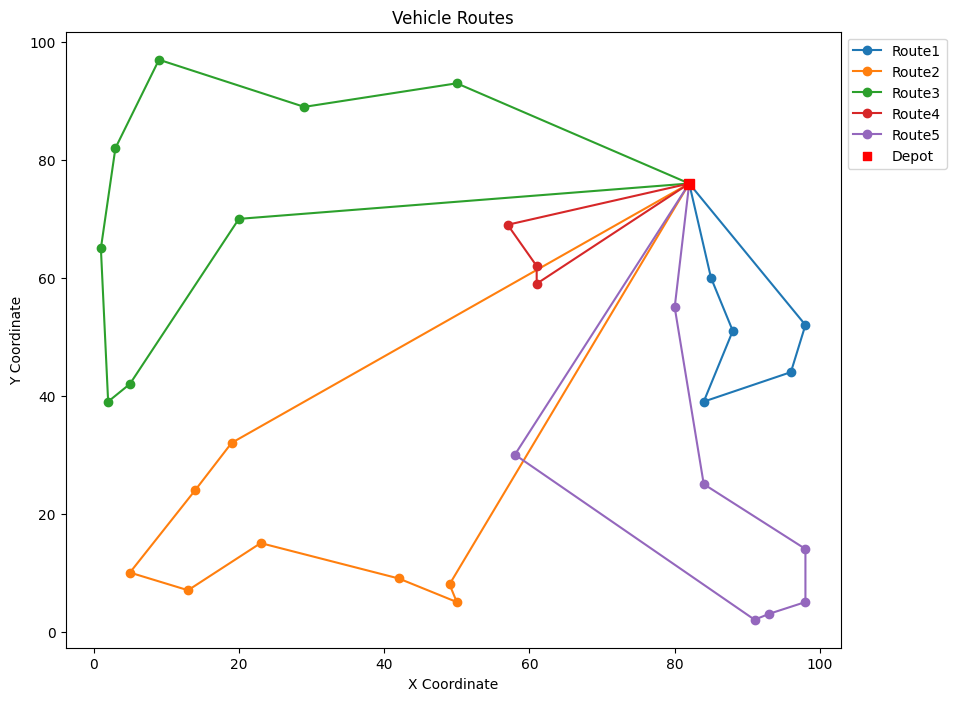

In [15]:
import time

start = time.time()
best_solution, best_cost = genetic_algorithm(coordinates, distance_matrix, demands, Q, k, pop_size = 1000, generations= 20)
end = time.time()

routes = {}
for i in range(len(best_solution)):
    routes[i] = best_solution[i]
'''
gap = ((best_cost - solution_cost) / solution_cost) * 100

for i, route in enumerate(best_solution):
    print(f"Route {i+1}: {route}")

print(f"Total Cost: {best_cost:.2f}")
print(f"Total Time: {time:.2f}")
print(f"Gap: {gap:.2f}%")'''

print_results(routes, coordinates)